Name: Andrew Porter

# Neural Network Architecture for CIFAR-10 Image Classification



## Dataset Loading:



Various data augmentation techniques were experimented with. The augmentation which worked best was adapted from: https://medium.com/swlh/how-data-augmentation-improves-your-cnn-performance-an-experiment-in-pytorch-and-torchvision-e5fb36d038fb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data Preprocessing
transform1 = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform2 = transforms.Compose([transforms.ToTensor(),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform1)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform2)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



100%|██████████| 170498071/170498071 [00:11<00:00, 14870323.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified




### Intermediate Blocks/Attention Mechanism:





In [ ]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_layers, stride=1, padding=1, apply_relu=True):
        super(IntermediateBlock, self).__init__()

        self.layers = nn.ModuleList()
        self.fc = nn.Linear(in_channels, num_layers)
        self.apply_relu = apply_relu

        for _ in range(num_layers):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
            ]
            if self.apply_relu:
                layers.append(nn.ReLU(inplace=True))
            self.layers.append(nn.Sequential(*layers))

    def forward(self, x):
        m = torch.mean(x, dim=[2, 3]) # Computes the mean across the height (H) and width (W) dimensions of each feature map or channel
        a = F.softmax(self.fc(m), dim=1)

        weighted_outputs = []
        for i, layer in enumerate(self.layers):
            output = layer(x)

            weight = a[:, i].view(-1, 1, 1, 1) #  Retrieves the weight for the current layer from 'a' (the softmax output), ensuring it has the shape [batch_size, 1, 1, 1]
            weighted_output = output * weight
            weighted_outputs.append(weighted_output)

        x_prime = sum(weighted_outputs)
        return x_prime


### Residual Macro Blocks (Inspired by ResNet):


In [ ]:
class ResidualMacroBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, module):
        super(ResidualMacroBlock, self).__init__()
        self.module = module
        self.match_dimensions = in_channels != out_channels
        if self.match_dimensions:
            # Projection to match dimensions via 1x1 convolution
            self.projection = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        if self.match_dimensions:
            identity = self.projection(x)
        else:
            identity = x
        return identity + self.module(x)


### Putting It Together: CIFAR-10 Classifier



The number of in channels and out channels for each block was inspired by: https://github.com/BAIDU-USA-GAIT-LEOPARD/CIFAR10-Distributed-Training-BaiduNet9P/commit/df05b74663f21d4cbed894590535fab9a79d4d32#diff-364b5d93e0a68ffc381ba38e21e7cd4161d67733563dae9220eb2b4655785d8a

The additional block hyperparameters, as well as the use of an individual layer to reduce feature space after final residual block inspired by: https://github.com/wbaek/torchskeleton/releases/tag/v0.2.1_dawnbench_cifar10_release


In [ ]:
class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()

        self.block1 = IntermediateBlock(in_channels=3, out_channels=64, kernel_size=3, num_layers=2)

        self.block2 = IntermediateBlock(in_channels=64, out_channels=128, kernel_size=5, padding=2, stride=2, num_layers=2)

        self.residual1 = ResidualMacroBlock(in_channels=128, out_channels=256, module=torch.nn.Sequential(
        IntermediateBlock(in_channels=128, out_channels=256, kernel_size=3, stride=1, num_layers=2),
        IntermediateBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, num_layers=2),))

        self.block3 = IntermediateBlock(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1, num_layers=2)

        self.residual2 = ResidualMacroBlock(in_channels=384, out_channels=384, module=torch.nn.Sequential(
            IntermediateBlock(in_channels=384, out_channels=384, kernel_size=3, stride=1, num_layers=2),
            IntermediateBlock(in_channels=384, out_channels=384, kernel_size=3, stride=1, num_layers=2),))

        self.individual_layer = nn.Sequential(
                nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=0),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True))


        self.apply_max_pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.output_block = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128,10, bias=False)
        )

    def forward(self, x):

        x = self.block1(x)
        x = self.block2(x)
        x = self.residual1(x)
        x = self.apply_max_pool(x)
        x = self.block3(x)
        x = self.residual2(x)
        x = self.apply_max_pool(x)
        x = self.individual_layer(x)
        x = self.output_block(x)

        return x



### Training Procedure


In [ ]:
import time

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)

def correct(model, y):
    y_hat = model.argmax(axis=1)
    return (y_hat == y).float().sum()

def evaluate_metric(model, data_loader, metric):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            total_correct += metric(logits, y)
            total_samples += y.size(0)
    return (total_correct / total_samples)*100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CIFAR10Classifier().to(device)
model.apply(init_weights)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=2e-2)
criterion = nn.CrossEntropyLoss()

losses = []
train_accs = []
test_accs = []

num_epochs = 75

for epoch in range(num_epochs):
    model.train()
    start_time = time.perf_counter()


    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    train_acc = evaluate_metric(model, train_loader, correct)
    test_acc = evaluate_metric(model, test_loader, correct)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    end_time = time.perf_counter()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {losses[-1]:.4f}, '
          f'Training Accuracy: {train_accs[-1]:.2f}, '
          f'Testing Accuracy: {test_accs[-1]:.2f}, '
          f'Duration: {end_time - start_time:.3f}s')


Epoch 1/75, Loss: 1.0287, Training Accuracy: 62.65, Testing Accuracy: 65.19, Duration: 89.600s
Epoch 2/75, Loss: 0.5697, Training Accuracy: 74.25, Testing Accuracy: 74.83, Duration: 88.445s
Epoch 3/75, Loss: 0.8599, Training Accuracy: 78.72, Testing Accuracy: 78.41, Duration: 89.240s
Epoch 4/75, Loss: 0.8109, Training Accuracy: 80.31, Testing Accuracy: 79.32, Duration: 89.438s
Epoch 5/75, Loss: 0.8237, Training Accuracy: 81.60, Testing Accuracy: 78.80, Duration: 90.306s
Epoch 6/75, Loss: 1.1592, Training Accuracy: 85.92, Testing Accuracy: 83.37, Duration: 90.369s
Epoch 7/75, Loss: 0.7655, Training Accuracy: 87.42, Testing Accuracy: 85.20, Duration: 90.158s
Epoch 8/75, Loss: 0.2893, Training Accuracy: 88.01, Testing Accuracy: 84.93, Duration: 89.775s
Epoch 9/75, Loss: 0.5020, Training Accuracy: 90.29, Testing Accuracy: 86.59, Duration: 89.805s
Epoch 10/75, Loss: 0.5058, Training Accuracy: 91.05, Testing Accuracy: 87.30, Duration: 89.453s
Epoch 11/75, Loss: 0.5162, Training Accuracy: 91.

Graphs:


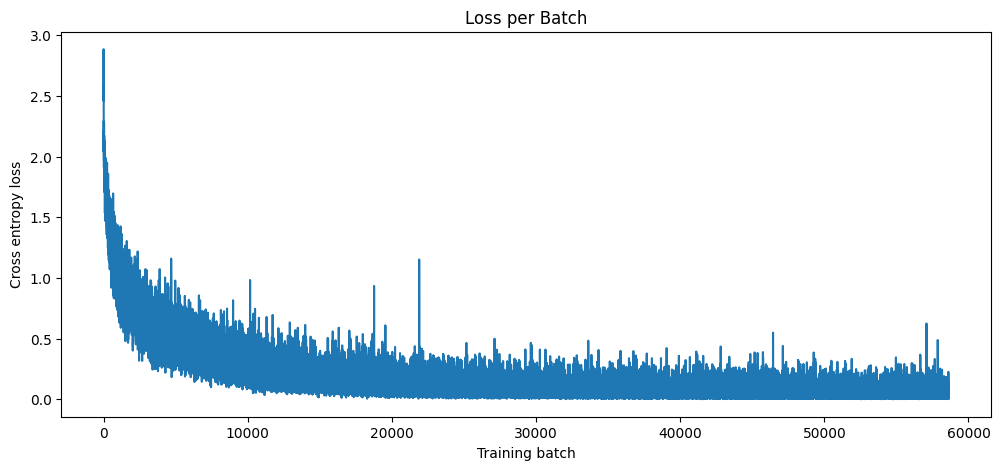

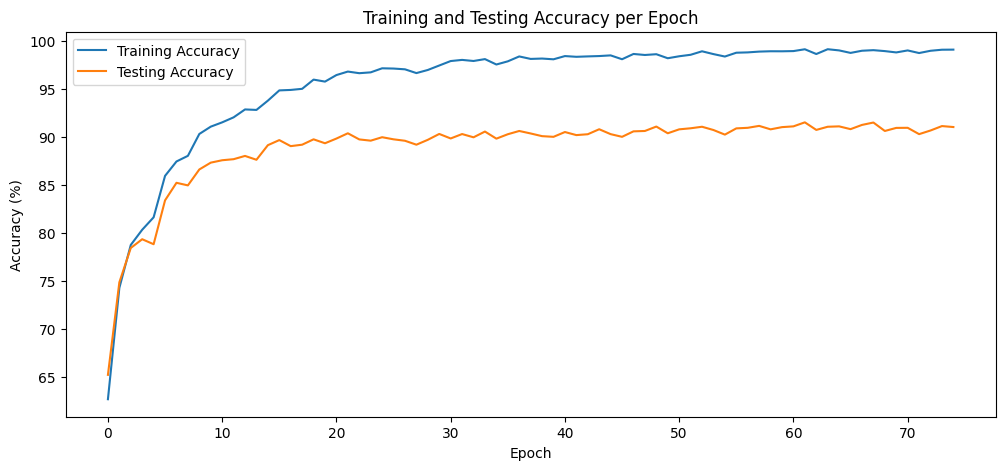

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(losses) # Plots the loss for each training batch
plt.title('Loss per Batch')
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')

plt.show()

train_accs_cpu = [acc.item() for acc in train_accs]
test_accs_cpu = [acc.item() for acc in test_accs]


plt.figure(figsize=(12, 5))

# Uses the CPU-converted lists for plotting
plt.plot(train_accs_cpu, label='Training Accuracy')
plt.plot(test_accs_cpu, label='Testing Accuracy')
plt.title('Training and Testing Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
